In [26]:
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
import emlp

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from jax import vmap
from scipy.ndimage import rotate
from emlp.groups import D, C
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

from emlp.reps import Scalar, Vector, T



<Figure size 432x288 with 0 Axes>

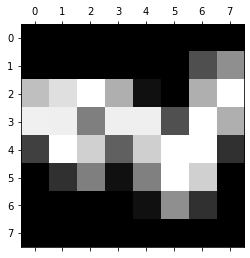

In [7]:
plt.gray()
plt.matshow(rotate(digits.images[2], 90))

In [1]:
MNIST_TRAIN_SIZE = 60000
MNIST_TEST_SIZE = 10000
SKLEARN_DIGITS_TRAIN_SIZE = 1247
SKLEARN_DIGITS_TEST_SIZE = 550


def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#


def train_emlp(G, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384,
               batch_size=500, lr=3e-3, num_epochs=5):

    rep_in = 28 * Scalar
    rep_out = 1 * Scalar
    model = emlp.nn.EMLP(rep_in, rep_out, group=G, num_layers=num_layers, ch=channels)
  
    opt = objax.optimizer.Adam(model.vars())
        
    @objax.Jit
    @objax.Function.with_vars(model.vars())
    def loss(x, y):
        yhat = model(x)
        return ((yhat-y)**2).mean()

    grad_and_val = objax.GradValues(loss, model.vars())

    
    @objax.Jit
    @objax.Function.with_vars(model.vars()+opt.vars())
    def train_op(x, y, lr):
        g, v = grad_and_val(x, y)
        opt(lr=lr, grads=g)
        return v

  
    train_losses = []
    test_losses = []
    for epoch in tqdm(range(num_epochs)):
        train_losses.append(np.mean([train_op(jnp.array(x), jnp.array(y),lr) for (x,y) in train]))
        if not epoch % 10:
            test_losses.append(np.mean([loss(jnp.array(x), jnp.array(y)) for (x,y) in test]))
  
    #print(f"Average test equivariance error {np.mean([equivariance_err(G, train, mb) for mb in testloader]):.2e}")
    return train_losses, test_losses

def equivariance_err(G, train, mb):
    rin,rout = train.rep_in(G),train.rep_out(G)
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

def compare_groups(grps, train=Inertia(1000), test=Inertia(2000), num_layers=3, channels=384
                   , batch_size=5, lr=3e-3, num_epochs=5):
    for name, G in grps.items():
        train_losses, test_losses = train_emlp(G, train, test, num_layers, channels, batch_size, lr, num_epochs)
        plt.plot(np.arange(num_epochs), train_losses, label=name + ' train loss')
        plt.plot(np.arange(0, num_epochs, 10), test_losses, label=name+' test loss')
    plt.legend()
    plt.yscale('log')
    plt.show()

    
def get_sklearn_digits_dataset(loader):
    """Downloads Sklearn handwritten digits dataset.
    Uses the last SKLEARN_DIGITS_TEST_SIZE examples as the test
    This is (hard-coded) -- do not change.
    Parameters
    ----------
    loader : str (values: 'train' or 'test')."""
    from torch.utils.data import Dataset
    from sklearn.datasets import load_digits

    class TorchDataset(Dataset):
        """Abstracts a numpy array as a PyTorch dataset."""

        def __init__(self, data, targets, transform=None):
            self.data = torch.from_numpy(data).float()
            self.targets = torch.from_numpy(targets).long()
            self.transform = transform

        def __getitem__(self, index):
            x = self.data[index]
            y = self.targets[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.data)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    # Get sklearn digits dataset
    X_all, y_all = load_digits(return_X_y=True)
    X_all = X_all.reshape((len(X_all), 8, 8))
    y_train = y_all[:-SKLEARN_DIGITS_TEST_SIZE]
    y_test = y_all[-SKLEARN_DIGITS_TEST_SIZE:]
    X_train = X_all[:-SKLEARN_DIGITS_TEST_SIZE]
    X_test = X_all[-SKLEARN_DIGITS_TEST_SIZE:]
    if loader == 'train':
        return  TorchDataset(X_train, y_train, transform=transform)
    elif loader == 'test':
        return TorchDataset(X_test, y_test, transform=transform)
    else:  # prama: no cover
        raise ValueError("loader must be either str 'train' or str 'test'.")
    

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trainloader = get_sklearn_digits_dataset("train")
testloader = get_sklearn_digits_dataset("test")


d8 = D(8)
c4 = C(4)
c2 = C(2)
groups = {'D8': d8, "C4": c4, "C(2)": c2}
print(groups.items())
compare_groups(groups, train=trainloader, test=testloader)

NameError: name 'Inertia' is not defined

In [69]:
rep_in = 28 * Scalar
rep_out = 10 * Scalar
model = emlp.nn.EMLP(rep_in, rep_out, group=D(8), num_layers=3, ch=318)
  
opt = objax.optimizer.Adam(model.vars())

predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars())
        

@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    return ((yhat-y)**2).mean()

grad_and_val = objax.GradValues(loss, model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v

trainloader = get_sklearn_digits_dataset("train")
testloader = get_sklearn_digits_dataset("test")

num_epochs = 500
lr = 0.01
train_losses = []
test_losses = []
lol = []
for epoch in tqdm(range(num_epochs)):
    train_losses.append(np.mean([train_op(jnp.array(x), jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch % 10:
        test_losses.append(np.mean([loss(jnp.array(x), jnp.array(y)) for (x,y) in testloader]))

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [56]:
print(model.vars())

(EMLP).network(Sequential)[0](EMLPBlock).linear(Linear).b          374 (374,)
(EMLP).network(Sequential)[0](EMLPBlock).linear(Linear).w          748 (374, 2)
(EMLP).network(Sequential)[0](EMLPBlock).bilinear(BiLinear).w    54469 (54469,)
(EMLP).network(Sequential)[1](EMLPBlock).linear(Linear).b          374 (374,)
(EMLP).network(Sequential)[1](EMLPBlock).linear(Linear).w       118932 (374, 318)
(EMLP).network(Sequential)[1](EMLPBlock).bilinear(BiLinear).w    54469 (54469,)
(EMLP).network(Sequential)[2](EMLPBlock).linear(Linear).b          374 (374,)
(EMLP).network(Sequential)[2](EMLPBlock).linear(Linear).w       118932 (374, 318)
(EMLP).network(Sequential)[2](EMLPBlock).bilinear(BiLinear).w    54469 (54469,)
(EMLP).network(Sequential)[3](Linear).b                              1 (1,)
(EMLP).network(Sequential)[3](Linear).w                            318 (1, 318)
+Total(11)                                                      403460


In [67]:
print(torch.cuda.is_available(),
torch.cuda.current_device(),
torch.cuda.device(0),
torch.cuda.device_count(),
torch.cuda.get_device_name(0))

True 0 <torch.cuda.device object at 0x7f956c109e80> 1 Quadro RTX 5000


In [17]:
import sys
!{sys.executable} -m pip install torchvision